# Implementacja algorytmu Deutscha-Jozsy

## Alicja Barankiewicz


Implentacja korzysta z biblioteki do obliczeń kwantowych `qiskit`. Najpierw należy ją zaimportować...

In [9]:
# zaimportuj Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile

# zaimportuj narzędzie Qiskit do wizualizacji
from qiskit.visualization import plot_histogram

# initialization
import numpy as np

# Parametry

In [7]:
qn = 4 #Liczba kubitów
balanced_function = True #Wybór funkcji stałej lub zbalansowanej

# Utworzenie wyroczni implementującej funkcję zbalansowaną lub stałą

In [10]:
def generate_oracle(balanced, n):
    oracle_qc = QuantumCircuit(n+1)
    
    if balanced == True:
        # Wygeneruj losowy ciąg bitów, żeby określić, na których kubitach użyć bramki X
        if n <= 10:
            pot = n
        else:
            pot = 16  
        b = np.random.randint(1,2**pot)
        b_str = format(b, '0'+str(n)+'b')
        
        #Iteracja przez ciąg bitów; jeżeli znak to 0 - nie rób nic, jeżeli 1 - użyj bramki X
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

        #Zbalansowanie wyroczni poprzez zastosowanie bramek CNOT
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
            
        # Powtórzenie bramek X
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    if balanced == False:
        #Najpierw losowy generujemy 0 lub 1, następnie tworzymy wyrocznię, która zwraca jedynie wygenerowaną liczbę
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Wyrocznia Uf" # To show when we display the circuit
    return oracle_gate
    

# Algorytm Deutscha-Jozsy

In [5]:
def deutsch_jozsa(oracle):
    # W wyroczni jest jeden kubit więcej, niż znaków wejściowych funkcji f
    n = oracle.num_qubits - 1; 
    
    #Utworzenie obwodu kwantowego
    final_circuit = QuantumCircuit(n+1, n)
    
    # Krok 1:
    final_circuit.x(n)
    final_circuit.h(n)
    for qubit in range(n):
        final_circuit.h(qubit)
        
    # Krok 2:
    final_circuit.append(oracle, range(n+1))
    
    # Krok 3:
    for qubit in range(n):
        final_circuit.h(qubit)
        
    # Krok 4:
    for i in range(n):
        final_circuit.measure(i, i)
    
    return final_circuit

# Wizualizacja obwodu algorytmu Deutscha-Jozsy

In [11]:
oracle_gate = generate_oracle(balanced_function, qn)
circuit = deutsch_jozsa(oracle_gate)
circuit.draw()

┌───┐     ┌───────────────┐┌───┐┌─┐         
q_0: ┤ H ├─────┤0              ├┤ H ├┤M├─────────
     ├───┤     │               │├───┤└╥┘┌─┐      
q_1: ┤ H ├─────┤1              ├┤ H ├─╫─┤M├──────
     ├───┤     │               │├───┤ ║ └╥┘┌─┐   
q_2: ┤ H ├─────┤2 Wyrocznia Uf ├┤ H ├─╫──╫─┤M├───
     ├───┤     │               │├───┤ ║  ║ └╥┘┌─┐
q_3: ┤ H ├─────┤3              ├┤ H ├─╫──╫──╫─┤M├
     ├───┤┌───┐│               │└───┘ ║  ║  ║ └╥┘
q_4: ┤ X ├┤ H ├┤4              ├──────╫──╫──╫──╫─
     └───┘└───┘└───────────────┘      ║  ║  ║  ║ 
c: 4/═════════════════════════════════╩══╩══╩══╩═
                                      0  1  2  3

# Wynik algorytmu w symulatorze kwantowym

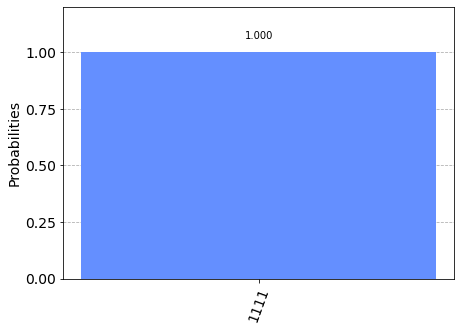

In [12]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_circuit = transpile(circuit, aer_sim)
qobj = assemble(transpiled_circuit)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)

Na wyjściu algorytmu wartość '0' oznacza, że funkcja jest stała, '1' - że jest zbalansowana

# Wykonanie na procesorze kwantowym

Najpierw należy pobrać nazwę procesora, który jest aktualnie najmniej zajęty:

#### UWAGA 1: Aby wykonać kod na rzeczywistym procesorze kwantowym, należy najpierw zachować token API IBM Quantum Lab za pomocą funkcji IBMQ.save_account(TOKEN)
#### UWAGA 2: Niekomercyjny procesor kwantowy IBM Quantum Lab obsługuje długość wejścia qn <= 4

In [13]:
#IBMQ.save_account('')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (qn+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("Najmniej zajęty procesor: ", backend)

Najmniej zajęty procesor:  ibmq_quito


Po znalezieniu procesora, można wykonać na nim algorytm:

In [14]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

transpiled_circuit = transpile(circuit, backend, optimization_level=3)
job = backend.run(transpiled_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


Oraz wyświetlić wyniki:

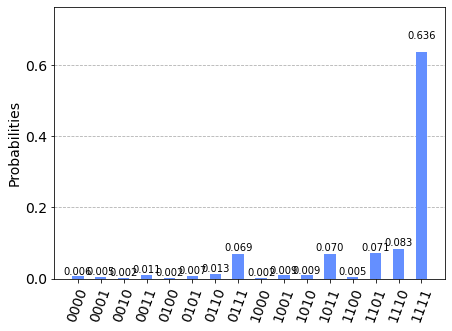

In [15]:
# Get the results of the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

Jak widać, największe prawdopodobieństwo przypada na wynik 0...0 - wskazujący, że funkcja jest stała, lub 1...1 - wskazujący, że funkcja jest zbalansowana. Pozostałe szczątkowe prawdopodobieństwa wynikają z szumu informacyjnego występującego w procesorach kwantowych.